In [1]:
# !pip install -r ../requirements.txt

In [2]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [3]:
FUEL_COUNT_FILE = "../data/processed/5_fuel_type_fire_analysis.csv"
PROV_VIZ_ANALYSIS = lambda prov: f"../assets/visulizations/fuel_type_growth_{prov}.png"

In [4]:
# Metadata from "https://cwfis.cfs.nrcan.gc.ca/downloads/nbac/nbac_1972_2023_20240530_shp_metadata.pdf" Pages 22-23
province_label = {
    "AB": "Alberta",
    "BC": "British Columbia",
    "MB": "Manitoba",
    "NB": "New Brunswick",
    "NL": "Newfoundland and Labrador",
    "NS": "Nova Scotia",
    "NT": "Northwest Territories",
    "NU": "Nunavut",
    "ON": "Ontario",
    "PC": "Parks Canada",
    "PE": "Prince Edward Island",
    "QC": "Quebec",
    "SK": "Saskatchewan",
    "YT": "Yukon Territory",
}

short_prov_label = {province_label[short_prov]: short_prov for short_prov in province_label}

In [5]:
color_label = [
    [-9999, (255, 255, 255, 255), ""],
    [1, (209, 255, 115, 255), "C-1 Spruce-Lichen Woodland"],
    [2, (34, 102, 51, 255), "C-2 Boreal Spruce"],
    [3, (131, 199, 149, 255), "C-3 Mature Jack or Lodgepole Pine"],
    [4, (112, 168, 0, 255), "C-4 Immature Jack or Lodgepole Pine"],
    [5, (223, 184, 230, 255), "C-5 Red and White Pine"],
    [7, (112, 12, 242, 255), "C-7 Ponderosa Pine / Douglas Fir"],
    [11, (196, 189, 151, 255), "D-1 Leafless Aspen"],
    [13, (196, 189, 151, 255), "D-1/D-2 Aspen"],
    [31, (255, 255, 190, 255), "O-1a Matted Grass"],
    [101, (130, 130, 130, 255), "Non-fuel"],
    [102, (115, 223, 255, 255), "Water"],
    [105, (204, 204, 204, 255), "Vegetated Non-Fuel"],
    [415, (255, 211, 127, 255), "M-1 Boreal Mixedwood - Leafless (15% Conifer)"],
    [625, (255, 211, 127, 255), "M-1/M-2 Boreal Mixedwood (25% Conifer)"],
    [650, (255, 211, 127, 255), "M-1/M-2 Boreal Mixedwood (50% Conifer)"],
    [675, (255, 211, 127, 255), "M-1/M-2 Boreal Mixedwood (75% Conifer)"],
]

# Convert RGBA values (0-255) to Matplotlib format (0-1)
color_dict = {entry[0]: np.array(entry[1]) / 255 for entry in color_label}
label_color_dict = {entry[2]: np.array(entry[1]) / 255 for entry in color_label}
label_dict = {entry[0]: entry[2] for entry in color_label}

# Create colormap & normalizer
unique_values = list(color_dict.keys())
colors = [color_dict[val] for val in unique_values]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(unique_values + [max(unique_values) + 1], cmap.N)

In [6]:
combined_label_dict = {
    "M-1/M-2 Boreal Mixedwood" : [
        "M-1 Boreal Mixedwood - Leafless (15% Conifer)",
        "M-1/M-2 Boreal Mixedwood (25% Conifer)",
        "M-1/M-2 Boreal Mixedwood (50% Conifer)",
        "M-1/M-2 Boreal Mixedwood (75% Conifer)"
    ],
    "D-1/D-2 Aspen ": [
        "D-1 Leafless Aspen",
        "D-1/D-2 Aspen"
    ]
}

In [7]:
def filter_to_fire_region(
    image_data, 
    no_data_val:int = -9999
):
    filtered_image = image_data[0][image_data[0] != no_data_val]
    del image_data
    return filtered_image

In [8]:
def get_fuel_type_counts(
    filtered_data
):
    fuel_types, counts = np.unique(
        filtered_data, 
        return_counts=True
    )
    count_dict = {
        int(fuel_type): int(count) 
        for fuel_type, count in zip(fuel_types, counts)
    }
    del fuel_types
    del counts
    return count_dict

In [9]:
def get_year(
    file_name:str
):
    return file_name.split("_")[1]

In [10]:
def get_labels(
    fuel_types:list,
    all_labels:dict = label_dict
):
    return [all_labels[fuel_id] for fuel_id in fuel_types]

def get_colors(
    fuel_types:list,
    all_colors:dict = color_dict
):
    return [all_colors[fuel_id] for fuel_id in fuel_types]

In [11]:
def make_yearly_percent_df(
    data,
    year_col:str = 'year',
):
    # make percentages by year
    data = data.set_index(
        year_col
    )
    data = data.div(
        data.sum(axis=1), 
        axis=0
    ) * 100
    data = data.reset_index()

    return data

In [12]:
def get_prov_data(
    data,
    prov: str,
    prov_col:str = 'provience',
    year_drop_list:list = [],
    year_col:str = 'year'
):    
    data = data[data[prov_col] == prov].drop(
        prov_col,
        axis = 1
    )

    # temp discard 2023
    data = data[~data[year_col].isin(year_drop_list)]

    return data

In [13]:
def get_meleted_prov_data(
    data,
    year_col:str = 'year'
):
    # melt data
    data = data.melt(
        id_vars=year_col, 
        var_name='Fule Type', 
        value_name='percentage'
    )
    return data


In [14]:
# Create colored box handles
def plot_legend(
    color_dict:dict = label_color_dict,
    legend_anchor:tuple = (.5, -0.27),
    title:str = "Fuel Type"
):
    # make a copy since we will be deleting repeated values
    c_dict = deepcopy(color_dict)

    handles = [Patch(color=color_dict[fuel_type], label=fuel_type) for fuel_type in c_dict if fuel_type not in ['']]

    plt.legend(
        title=title, 
        handles=handles, 
        loc='lower center',
        bbox_to_anchor=legend_anchor, 
        frameon=True,
        ncol=3,
        fontsize=20,
        title_fontsize=35
    )

In [15]:
def plot_stacked_bar_chart_fuel_type(
    data_count,
    data_percent,
    figsize:tuple = (10, 3),
    legend_num_col:int = 6,
    legend_on:bool = True,
    legend_ancher:tuple = (.5, -0.42),
    year_col:str = 'year',
    fuel_type_col:str = 'Fule Type',
    title:str = '',
    bar_width:float = 0.38,
    bar_linewidth:float = 0.1,
    bar_linecolor:str = 'black',
    bar_percent_cutoff:int = 25,
):
    fig, ax1 = plt.subplots(
        figsize = figsize
    )
    # Create a twin axis
    ax2 = ax1.twinx()

    # convert pixel count to area in km^2
    data_count['percentage'] = data_count['percentage'] * 0.0009 #in km^2

    # track percentage bottom position
    prev_percent_bottom = np.zeros(
        len(data_percent[year_col].unique())
    )
    # track count bottom position
    prev_count_bottom = np.zeros(
        len(data_count[year_col].unique())
    )

    for fuel_type in data_percent[fuel_type_col].unique():
        # add percent bar
        fuel_percent_data_df = data_percent[data_percent[fuel_type_col] == fuel_type]
        ax1_x = fuel_percent_data_df[year_col] - bar_width/2
        ax1_y = fuel_percent_data_df['percentage']
        ax1.bar(
            ax1_x, 
            ax1_y, 
            width = bar_width,
            label=f'{fuel_type}',
            bottom = prev_percent_bottom,
            color=label_color_dict[fuel_type],
            edgecolor=bar_linecolor, 
            linewidth=bar_linewidth
        )
        # add percent labels
        for ax1_bar_index in range(len(ax1_x)):  
            year = ax1_x.iloc[ax1_bar_index]
            percent = ax1_y.iloc[ax1_bar_index]  
            if percent >= bar_percent_cutoff:
                ax1.text(
                    year, 
                    prev_percent_bottom[ax1_bar_index] + (percent)/2, 
                    f'{percent:.1f}%', 
                    ha='center',
                    va='center',
                    rotation=90,
                    fontsize=12, 
                    color='black' 
                )

        # keep track of the lower value
        prev_percent_bottom += fuel_percent_data_df['percentage'].values
        



        # add count bar
        fuel_count_data_df = data_count[data_count[fuel_type_col] == fuel_type]
        ax2.bar(
            fuel_count_data_df[year_col] + bar_width/2, 
            fuel_count_data_df['percentage'],
            width = bar_width,
            label = f'{fuel_type}',
            bottom = prev_count_bottom,
            color= 'indianred',
            # label_color_dict[fuel_type],
            # edgecolor=bar_linecolor, 
            # linewidth=bar_linewidth
        )
        prev_count_bottom += fuel_count_data_df['percentage'].values

    del prev_percent_bottom
    del prev_count_bottom

    ax1.set_xticks(data_percent[year_col].unique())
    
    # give axis label
    ax1.set_ylabel(
        "Yearly Fuel Type Growth % Post-Wildfire",
        color='steelblue'
    )
    ax2.set_ylabel(
        "Total Yearly Wildfire Area Burnt in $Km^2$",
        color='indianred'
    )

    # set pixel count (area) scale to log
    ax2.set_yscale('log')
    ax2.tick_params(
        axis='y', 
        colors='indianred',
        labelsize=10, 
    )

    
    # set ticks
    ax1.set_xticks(
        range(2005,2024,1),
    )
    ax1.tick_params(
        axis='x', 
        labelsize=10, 
    )

    # set ticks
    ax1.set_yticks(
        range(0,101,10),
    )
    ax1.tick_params(
        axis='y', 
        color='steelblue',
        labelsize=10, 
    )
    ax1.set_yticklabels(
        ax1.get_yticks(), 
        color='steelblue'
    )


    # add grid 
    ax1.grid(
        True, 
        axis='y', 
        linestyle=':', 
        color='steelblue', 
        alpha=0.5
    )
    ax2.grid(
        True, 
        axis='y', 
        linestyle='-.', 
        color='indianred', 
        alpha=0.5
    )
    
    if legend_on:
        ax1.legend(
            title="Fuel Type", 
            bbox_to_anchor=legend_ancher, 
            loc='lower center',
            ncol=legend_num_col,
        )
        
    plt.title(title)
    plt.show()

In [16]:
fule_count_df = pd.read_csv(
    FUEL_COUNT_FILE,
)
fule_count_df

,year,provience,C-1 Spruce-Lichen Woodland,C-2 Boreal Spruce,C-3 Mature Jack or Lodgepole Pine,C-4 Immature Jack or Lodgepole Pine,C-5 Red and White Pine,C-7 Ponderosa Pine / Douglas Fir,D-1 Leafless Aspen,D-1/D-2 Aspen,O-1a Matted Grass,Non-fuel,Water,Vegetated Non-Fuel,M-1 Boreal Mixedwood - Leafless (15% Conifer),M-1/M-2 Boreal Mixedwood (25% Conifer),M-1/M-2 Boreal Mixedwood (50% Conifer),M-1/M-2 Boreal Mixedwood (75% Conifer)
0,2005,Quebec,4269,550576,26629,582399,0,0,103953,4383163,228278,30486,223829,192836,1321289,1086512,97836,426692
1,2005,Ontario,6764,73318,9347,140847,3,0,21904,145824,18917,5359,3524,71,1246,36248,33225,32059
2,2005,Northwest Territories,909,69580,3958,90934,0,0,128892,898309,192408,12811,8955,60188,3626,229673,79509,80272
3,2005,British Columbia,11980,21318,14521,50035,2101,64,4108,48750,9893,398,274,57406,1744,37853,4191,9648
4,2005,Saskatchewan,0,128824,33116,1110402,0,0,108493,227506,81289,870,30824,86699,943,83549,62658,60825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2023,Yukon Territory,0,0,0,0,0,0,0,0,0,0,0,3483955,0,0,0,0
224,2023,Nova Scotia,0,0,0,0,0,0,0,0,0,0,0,253307,0,0,0,0
225,2023,Newfoundland and Labrador,0,0,0,0,0,0,0,0,0,0,0,203905,0,0,0,0
226,2023,Nunavut,0,0,0,0,0,0,0,0,0,0,0,45173,0,0,0,0


In [17]:
# drop water column as we dont want to show that info
fule_count_df.drop(
    'Water',
    axis = 1,
    inplace = True,
)

In [18]:
# combine the similar fuel types
for cobined_type in combined_label_dict:
    # merge the data
    fule_count_df[cobined_type] = fule_count_df[combined_label_dict[cobined_type]].sum(axis = 1)
    # deleted the old columns
    fule_count_df.drop(
        combined_label_dict[cobined_type],
        inplace = True,
        axis = 1
    )
    # fix the labels and colors 
    label_color_dict[cobined_type] = label_color_dict[combined_label_dict[cobined_type][0]]
    # for fuel_type in combined_label_dict[cobined_type]:
    #     del label_color_dict[fuel_type]      
fule_count_df

,year,provience,C-1 Spruce-Lichen Woodland,C-2 Boreal Spruce,C-3 Mature Jack or Lodgepole Pine,C-4 Immature Jack or Lodgepole Pine,C-5 Red and White Pine,C-7 Ponderosa Pine / Douglas Fir,O-1a Matted Grass,Non-fuel,Vegetated Non-Fuel,M-1/M-2 Boreal Mixedwood,D-1/D-2 Aspen
0,2005,Quebec,4269,550576,26629,582399,0,0,228278,30486,192836,2932329,4487116
1,2005,Ontario,6764,73318,9347,140847,3,0,18917,5359,71,102778,167728
2,2005,Northwest Territories,909,69580,3958,90934,0,0,192408,12811,60188,393080,1027201
3,2005,British Columbia,11980,21318,14521,50035,2101,64,9893,398,57406,53436,52858
4,2005,Saskatchewan,0,128824,33116,1110402,0,0,81289,870,86699,207975,335999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2023,Yukon Territory,0,0,0,0,0,0,0,0,3483955,0,0
224,2023,Nova Scotia,0,0,0,0,0,0,0,0,253307,0,0
225,2023,Newfoundland and Labrador,0,0,0,0,0,0,0,0,203905,0,0
226,2023,Nunavut,0,0,0,0,0,0,0,0,45173,0,0


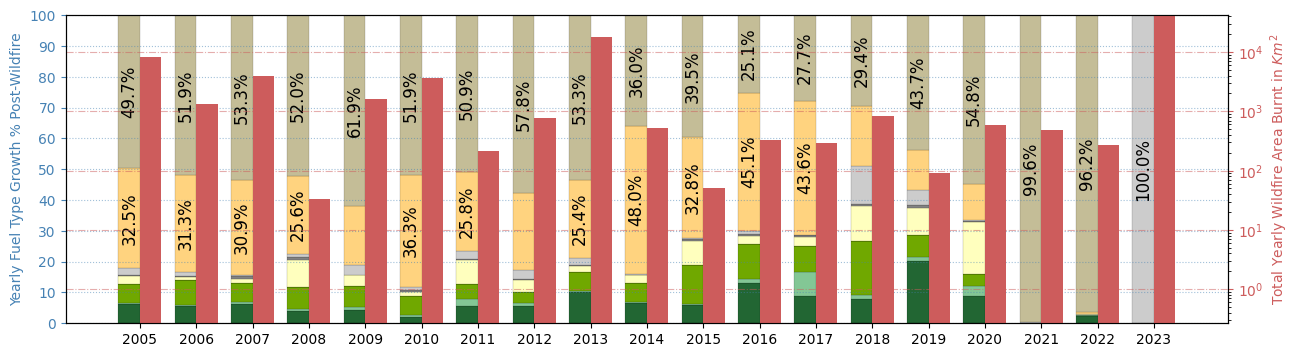

<Figure size 640x480 with 0 Axes>

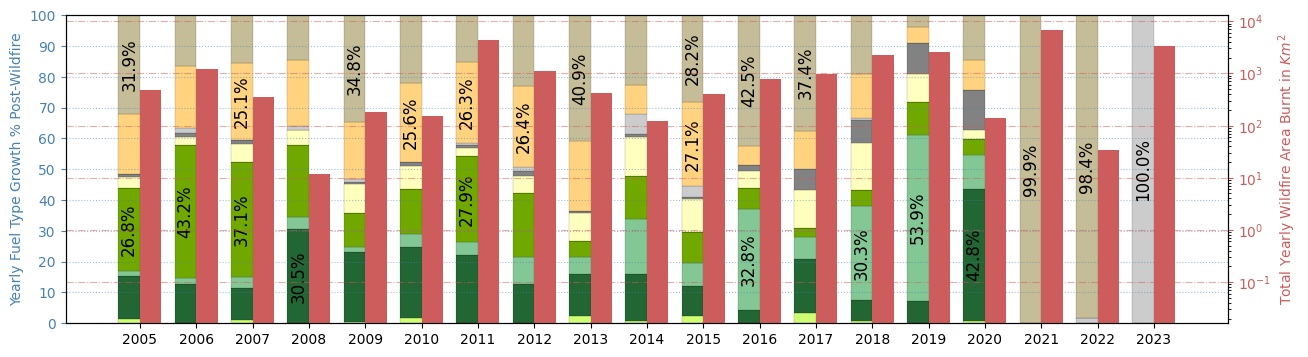

<Figure size 640x480 with 0 Axes>

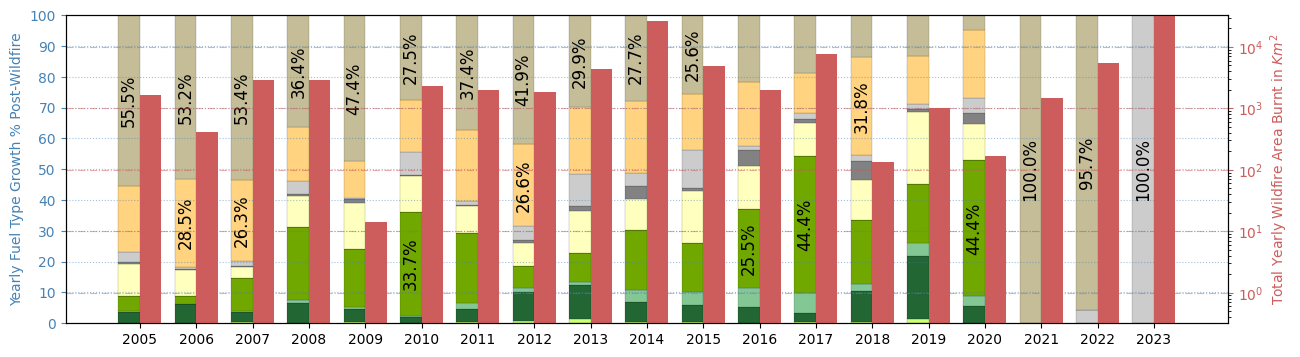

<Figure size 640x480 with 0 Axes>

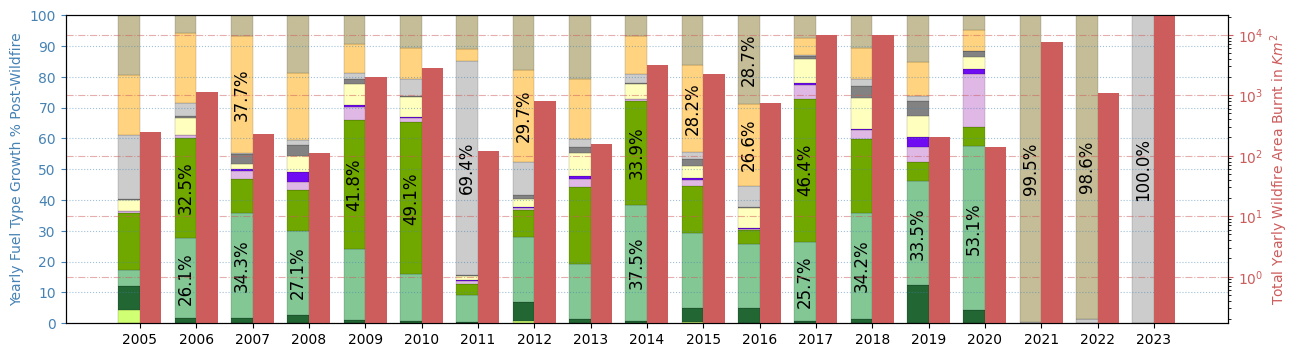

<Figure size 640x480 with 0 Axes>

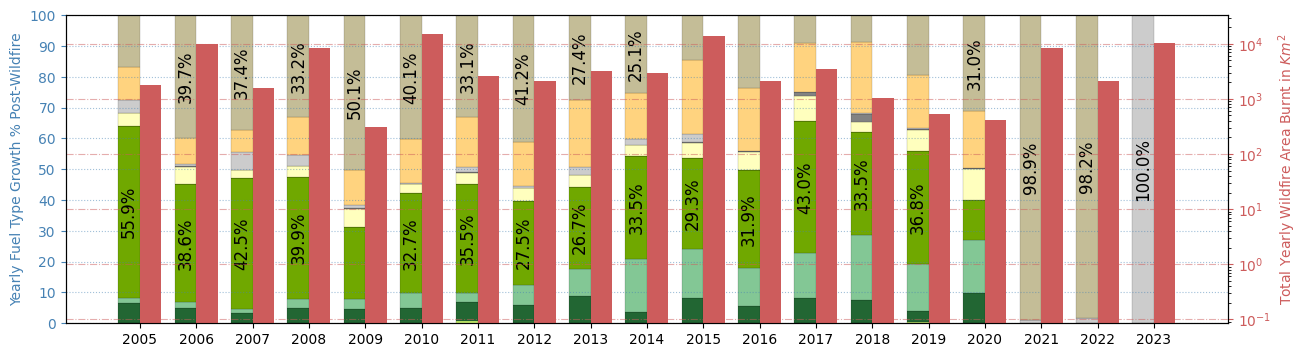

<Figure size 640x480 with 0 Axes>

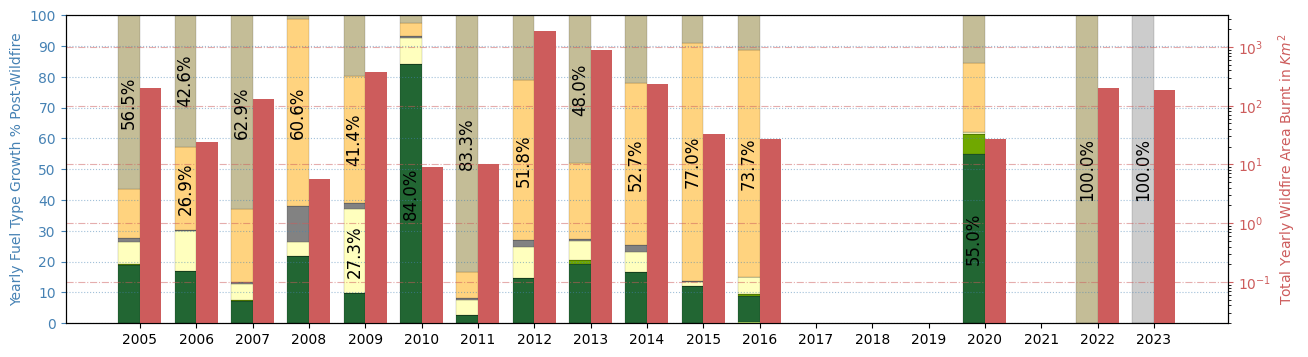

<Figure size 640x480 with 0 Axes>

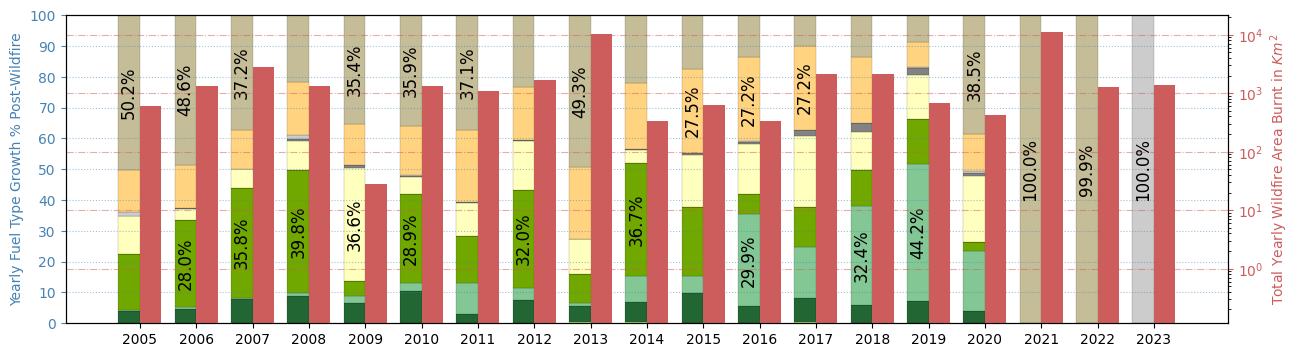

<Figure size 640x480 with 0 Axes>

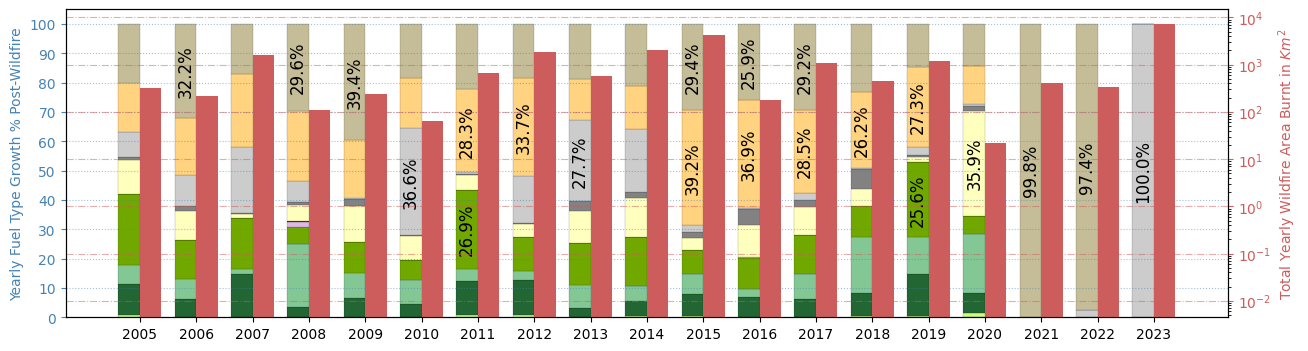

<Figure size 640x480 with 0 Axes>

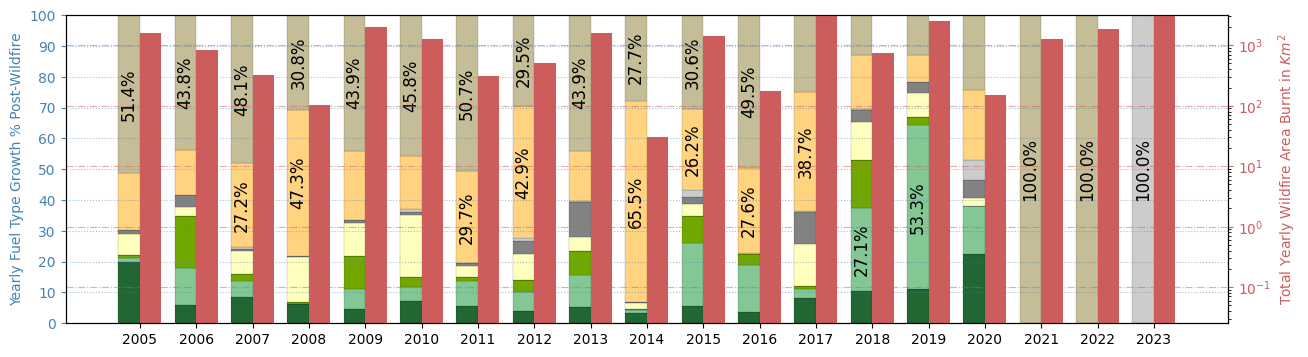

<Figure size 640x480 with 0 Axes>

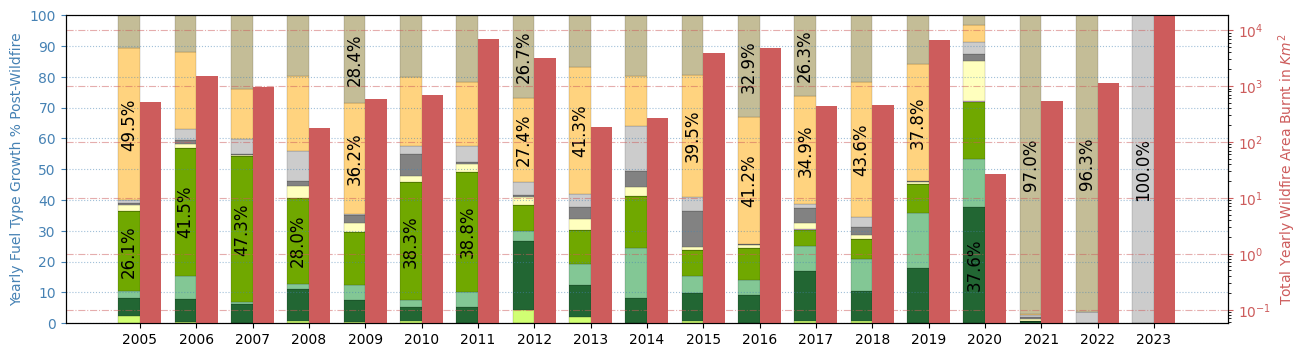

<Figure size 640x480 with 0 Axes>

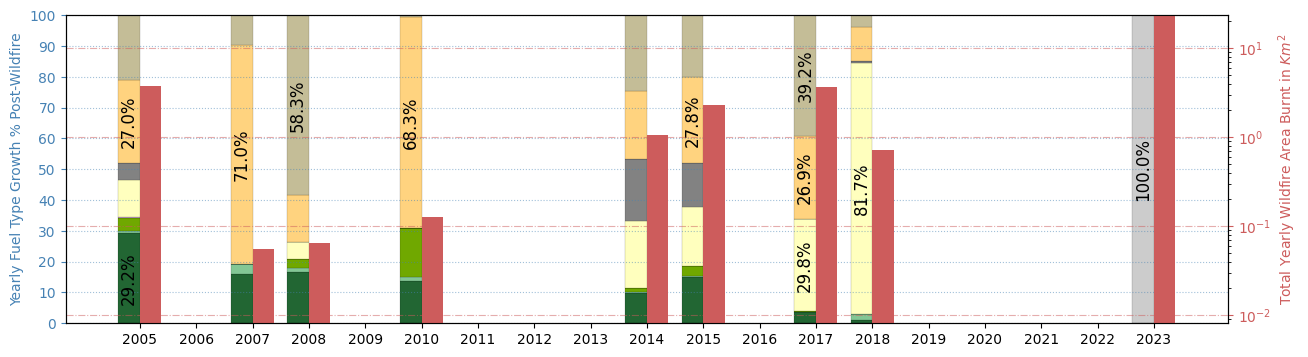

<Figure size 640x480 with 0 Axes>

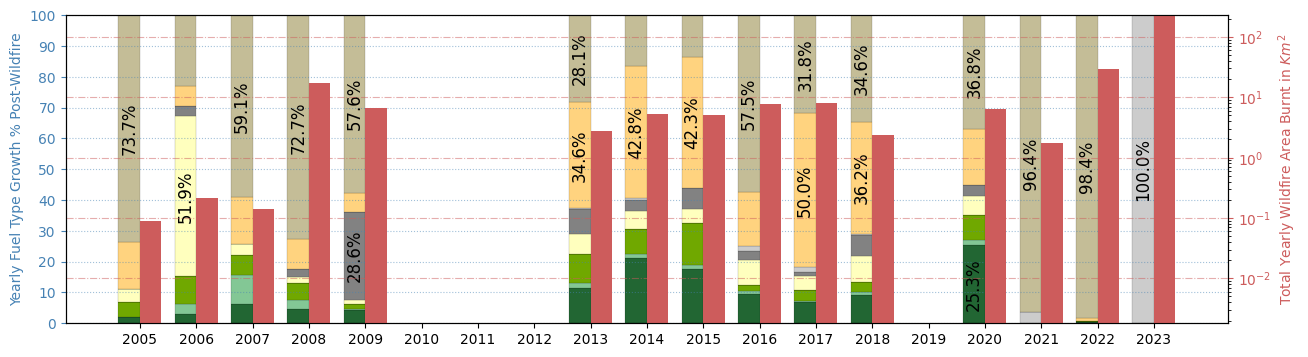

<Figure size 640x480 with 0 Axes>

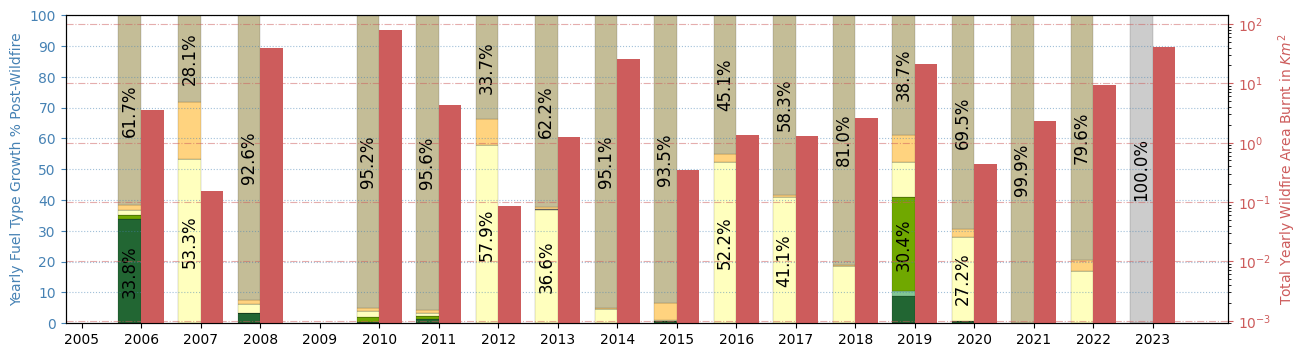

<Figure size 640x480 with 0 Axes>

In [19]:
for prov in fule_count_df['provience'].unique():
    # get fire count stats df matrix
    prov_count_df = get_prov_data(
        data = fule_count_df,
        prov = prov
    )
    # get fire percent stats df matrix
    prov_percent_df = make_yearly_percent_df(
        data = prov_count_df
    )
    
    # get fire count stats df 
    prov_count_df = get_meleted_prov_data(
        data = prov_count_df
    )

    # get fire percent stats df 
    prov_percent_df = get_meleted_prov_data(
        data = prov_percent_df
    )
    
    plot_stacked_bar_chart_fuel_type(
        data_count = prov_count_df,
        data_percent = prov_percent_df,
        legend_on = False,
        figsize = (15,4),
        # title = f"{prov}" # remove for overleaf
    )

    plt.savefig(
        PROV_VIZ_ANALYSIS(prov = prov.lower().replace(" ", ""))
    )